Bio-Informatique : Medical sentences classification of the PubMed 200k RCT dataset

Laurent Guiddir 

In [2]:
pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz (14.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imbalanced-learn

attention : au chemin pour les fichier, car je ne vous nous avez dit de pas vous les fournir, ils devront tous etre dans un dossier nommé PubMed_200k_RCT et tous unzippé. Sinon vous pouvez adapter le chemin pour vous.

In [4]:
# (Vous pouvez adaptez le chemin en fonction de la ou ils sont pour vous )
train_file = 'PubMed_200k_RCT/train.txt'
dev_file = 'PubMed_200k_RCT/dev.txt'
test_file = 'PubMed_200k_RCT/test.txt'

In [5]:
import pandas as pd
import numpy as np

First step :

Preprocessing 1 : For each file (train.txt, dev.txt and test.txt), we going to extract the sentences and their respective labels.

Computing so much data is extremly long for both the lemmatization and the training.
So i created a viriable SUBSET_SIZE where TRAIN_SUBSET_SIZE is at least five time bigger, so that we work with a computable amout of data for my machine.

In [6]:
SUBSET_SIZE = 20000
TRAIN_SUBSET_SIZE = 5*SUBSET_SIZE

def extract_sentences_and_labels(file, subset_size):
    sentences = []
    labels = []

    with open(file, 'r') as file:
        for line in file:
            if not line.startswith('###'):  # on ignore les identifiants des articles
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    label, sentence = parts
                    labels.append(label)
                    sentences.append(sentence)

                    if len(sentences) >= subset_size:
                        break
    return sentences, labels


# For the train.txt file
train_sentences, train_labels = extract_sentences_and_labels(train_file, TRAIN_SUBSET_SIZE)

# For the dev.txt file
dev_sentences, dev_labels = extract_sentences_and_labels(dev_file, SUBSET_SIZE)

# For the test.txt file
test_sentences, test_labels = extract_sentences_and_labels(test_file, SUBSET_SIZE)

Preprocessing 2 : we are going to lemmatize all the sentences of each file.

In [7]:
import spacy

nlp = spacy.load('en_core_sci_sm')

def sentences_lemmatization(sentences):
    lemmatized_sentences = []

    for doc in nlp.pipe(sentences, batch_size= 200):
        lemmatized_sentence = " ".join([token.lemma_ for token in doc])
        lemmatized_sentences.append(lemmatized_sentence)
    return lemmatized_sentences

c:\Users\test\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [8]:
train_lemmatized_sentences = sentences_lemmatization(train_sentences)

In [9]:
dev_lemmatized_sentences = sentences_lemmatization(dev_sentences)
test_lemmatized_sentences = sentences_lemmatization(test_sentences)

In [10]:
train_sentences_df = pd.DataFrame({'sentence': train_sentences,'lemmatized sentence': train_lemmatized_sentences, 'label': train_labels})
train_sentences_df['label'].value_counts()

RESULTS        34784
METHODS        32699
CONCLUSIONS    15218
BACKGROUND      8859
OBJECTIVE       8440
Name: label, dtype: int64

As we can see just above the differents class (labels) are very unbalanced. We will have to consider this when doing the training of the model to avoid the model to be biased. For exemple by weighting the classes for the training.

We are now going to use TF-IDF with unigram bag of words to extract the features.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer(ngram_range=(1,1) )

# X_train is a sparse matrix where each row is a sentence and each column is a word
X_train = vectorizer.fit_transform(train_lemmatized_sentences)
X_dev = vectorizer.transform(dev_lemmatized_sentences)
X_test = vectorizer.transform(test_lemmatized_sentences)

In [44]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train_labels)
y_dev = encoder.transform(dev_labels)
y_test = encoder.transform(test_labels)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, confusion_matrix

# train the model with wheigted classe
model_balanced = LogisticRegression(max_iter=10000, class_weight='balanced')
model_balanced.fit(X_train, y_train)

# predict on the dev set
y_pred_balanced = model_balanced.predict(X_dev)


label_names = encoder.classes_


def display_score(y, y_pred, label_names, title):
    print(title, ":")
    print(f"accuracy :  {accuracy_score(y, y_pred)}")
    print(f"balanced accuracy :  {balanced_accuracy_score(y, y_pred)}")
    print(classification_report(y, y_pred, target_names=label_names))



# we now evaluate the model
display_score(y_dev, y_pred_balanced, label_names, "logistic regression with balanced classes on unigrams")

logistic regression with balanced classes on unigrams :
accuracy :  0.769
balanced accuracy :  0.714326986906478
              precision    recall  f1-score   support

  BACKGROUND       0.48      0.55      0.51      1768
 CONCLUSIONS       0.67      0.72      0.69      3035
     METHODS       0.86      0.86      0.86      6609
   OBJECTIVE       0.55      0.65      0.60      1660
     RESULTS       0.89      0.78      0.83      6928

    accuracy                           0.77     20000
   macro avg       0.69      0.71      0.70     20000
weighted avg       0.78      0.77      0.77     20000



Just for the sake of comparaison, we are going create an other model but without wheiting the classes to see if there's an important difference of performance :

In [51]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_dev)


display_score(y_dev, y_pred, label_names, "logistic regression on unigrams")

logistic regression on unigrams :
accuracy :  0.786
balanced accuracy :  0.700663976675888
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.46      0.51      1768
 CONCLUSIONS       0.70      0.71      0.71      3035
     METHODS       0.83      0.89      0.86      6609
   OBJECTIVE       0.66      0.60      0.63      1660
     RESULTS       0.85      0.85      0.85      6928

    accuracy                           0.79     20000
   macro avg       0.72      0.70      0.71     20000
weighted avg       0.78      0.79      0.78     20000



We can see, that even though the normal model has a better accuracy than the weighted modele, the weighted one has a better balanced accuracy due significently better recall of the minority classes (due the increased sensitivity for minority classes induces by the wheighting). 

That being said the normal model has a better f1 on average score and for every single classe, even for the less represented classes so we are going to seelect keep this one.

Maybe we can improve our result even more buy using smote to resample our training data

In [52]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [53]:
model_resampled = LogisticRegression(max_iter=10000)
model_resampled.fit(X_train_resampled, y_train_resampled)

X_dev_resampled = vectorizer.transform(dev_lemmatized_sentences)
y_pred_resampled = model_resampled.predict(X_dev_resampled)


display_score(y_dev, y_pred_resampled, label_names, "dev set evaluation using using smote to resample the data and TF-IDF unigram")

dev set evaluation using using smote to resample the data and TF-IDF unigram :
accuracy :  0.76215
balanced accuracy :  0.697759292686321
              precision    recall  f1-score   support

  BACKGROUND       0.46      0.59      0.52      1768
 CONCLUSIONS       0.67      0.71      0.69      3035
     METHODS       0.86      0.86      0.86      6609
   OBJECTIVE       0.53      0.54      0.53      1660
     RESULTS       0.88      0.79      0.83      6928

    accuracy                           0.76     20000
   macro avg       0.68      0.70      0.69     20000
weighted avg       0.77      0.76      0.77     20000



Well, we can see that resampling the data with smote gave us worse result for all metric this artificial synthetic oversmpling was probably not rich enough to offset the lack of information that new and real sentences could have provided.

So we are going to select the normal for the first method.

---------------------------------------------------------------------------------------------------------------------------------------------
We are now going to use BioSentVect to make a second model using this pre-trained biomedical sentence embeddings. 

the model is available at this link (21Go) : https://github.com/ncbi-nlp/BioSentVec?tab=readme-ov-file#biosentvec


WARNING : 
 the command pip install sent2vec will get the wrong package. 



EDIT : I struggled way too much to get sent2vec to work on my windows machine but i ran into a lot of issues.
So not being able to set up sent2vec, i will not be able to use BioSentVec.

------------------------------------------------------------------------------------------------------------------------------

THEREFORE, i am going to use the PubMedBERT pre-trained model instead.

In [18]:
pip install -U sentence-transformers

In [19]:
from sentence_transformers import SentenceTransformer
model_BERT = SentenceTransformer("neuml/pubmedbert-base-embeddings")

c:\Users\test\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
embeddings_train = model_BERT.encode(train_lemmatized_sentences, show_progress_bar=True)

Batches: 100%|██████████| 3125/3125 [41:54<00:00,  1.24it/s] 


In [22]:
embeddings_dev = model_BERT.encode(dev_lemmatized_sentences, show_progress_bar=True)

Batches: 100%|██████████| 625/625 [08:28<00:00,  1.23it/s]


In [55]:
top_model = LogisticRegression(max_iter=10000)
top_model.fit(embeddings_train, y_train)

# predicting using top_model trained embeddings_train
dev_prediction_BERT = top_model.predict(embeddings_dev)
display_score(y_dev, dev_prediction_BERT, label_names, "dev set evaluation of predication using top_model which is trained on lemmatized sentences emmbedings")

dev set evaluation of predication using top_model which is trained on lemmatized sentences emmbedings :
accuracy :  0.82815
balanced accuracy :  0.7536186534149012
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.57      0.59      1768
 CONCLUSIONS       0.75      0.77      0.76      3035
     METHODS       0.89      0.92      0.91      6609
   OBJECTIVE       0.69      0.63      0.66      1660
     RESULTS       0.89      0.88      0.88      6928

    accuracy                           0.83     20000
   macro avg       0.76      0.75      0.76     20000
weighted avg       0.83      0.83      0.83     20000



As we expected the second technic gave us way better result since it was train it on embedding made by the PubMedBERT pre-trained model which is a state of the art medical embedding model. But we exracted the embeddiings from from the lemmatized version of the sentences so we probably missed some valuavle inforamation due to the sheer nature  of the lemmatization (lozercasing, plurals supresssion...). 

So lets extract the embedding from the full sentences and see if we can get better result.

In [24]:
fullSentence_embeddings_train = model_BERT.encode(train_sentences, show_progress_bar=True)

Batches: 100%|██████████| 3125/3125 [42:32<00:00,  1.22it/s] 


In [25]:
fullSentence_embeddings_dev = model_BERT.encode(dev_sentences, show_progress_bar=True)

Batches: 100%|██████████| 625/625 [08:37<00:00,  1.21it/s]


In [54]:
fullSentence_top_model = LogisticRegression(max_iter=10000)
fullSentence_top_model.fit(fullSentence_embeddings_train, y_train)

# predicting using top_model trained embeddings_train
fullSentence_dev_prediction_BERT = fullSentence_top_model.predict(fullSentence_embeddings_dev)
display_score(y_dev, fullSentence_dev_prediction_BERT, label_names, "dev set evaluation of predication made using fullSentence_top_model")

dev set evaluation of predication made using fullSentence_top_model :
accuracy :  0.8506
balanced accuracy :  0.7812170432394498
              precision    recall  f1-score   support

  BACKGROUND       0.65      0.62      0.64      1768
 CONCLUSIONS       0.80      0.80      0.80      3035
     METHODS       0.91      0.93      0.92      6609
   OBJECTIVE       0.69      0.65      0.67      1660
     RESULTS       0.90      0.90      0.90      6928

    accuracy                           0.85     20000
   macro avg       0.79      0.78      0.79     20000
weighted avg       0.85      0.85      0.85     20000



As expected, fullSentence_top_model is even better since we trained it on emmebding extracted from the full sentences.

So, our final two model, for each technic are :

for the first technic : model

and for the second technic : fullSentence_top_model

But now let's test the fullSentence_top_model on the test set and see if models did not overfit the training set.

In [40]:
fullSentence_embeddings_test = model_BERT.encode(test_sentences, show_progress_bar=True)

Batches: 100%|██████████| 625/625 [08:15<00:00,  1.26it/s]


In [59]:
fullSentence_test_prediction_BERT = fullSentence_top_model.predict(fullSentence_embeddings_test)
display_score(y_test, fullSentence_test_prediction_BERT, label_names, "test set evaluation of the prediction using our selected fullSentence_top_model")

test set evaluation of the prediction using our selected fullSentence_top_model :
accuracy :  0.8551
balanced accuracy :  0.7841298588427872
              precision    recall  f1-score   support

  BACKGROUND       0.67      0.62      0.64      1814
 CONCLUSIONS       0.80      0.79      0.80      2980
     METHODS       0.91      0.94      0.92      6716
   OBJECTIVE       0.70      0.67      0.68      1580
     RESULTS       0.91      0.91      0.91      6910

    accuracy                           0.86     20000
   macro avg       0.80      0.78      0.79     20000
weighted avg       0.85      0.86      0.85     20000



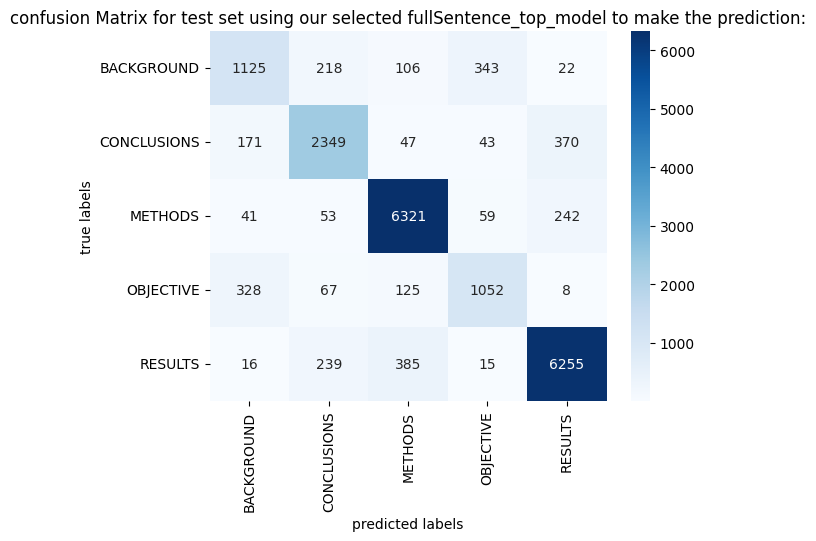

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_test, fullSentence_test_prediction_BERT)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('predicted labels')
plt.ylabel('true labels')
plt.title('confusion Matrix for test set using our selected fullSentence_top_model to make the prediction:')
plt.show()

Conclusion : we got an almost identical result on the test set for literally all the metrics and all the classes, so we can say that our model did not overfit and did a pretty good job at generalizing.

So finally our best model is fullSentence_top_model by far .